<a href="https://colab.research.google.com/github/delhian/recomender_systems/blob/main/RS_jester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Please see decription here http://eigentaste.berkeley.edu/dataset/

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from bs4 import BeautifulSoup as bs
from os import listdir
from os.path import isfile, join
pd.set_option('max_colwidth', 400)
import numpy as np
from collections import defaultdict
from surprise.model_selection import GridSearchCV

## Jokes

In [ ]:
%%time

filenames_path= './jokes/'

filenames = [f for f in listdir(filenames_path) if '.htm' in f]

jokes = []

for filename in filenames:
    joke_id = int(filename.split('.')[0].replace('init','')) - 1
    with open(join(filenames_path, filename), 'r',) as file:
        text = bs(file, 'lxml').body.text.replace('\n',' ').strip()
        jokes.append([joke_id, text])
        
jokes = pd.DataFrame(jokes, columns = ['joke_id', 'text'])
jokes = jokes.sort_values('joke_id').reset_index(drop=True)
print(jokes.shape)
jokes.head()

(100, 2)
CPU times: user 68 ms, sys: 8.81 ms, total: 76.8 ms
Wall time: 86.4 ms


,joke_id,text
0,0,"A man visits the doctor. The doctor says ""I have bad news for you.You have cancer and Alzheimer's disease"". The man replies ""Well,thank God I don't have cancer!"""
1,1,"This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him. ""What could they possibly have said to make you move out?"" ""They told me that you were a pedophile."" He replied, ""That's an awfully big word for a ten year old."""
2,2,Q. What's 200 feet long and has 4 teeth? A. The front row at a Willie Nelson Concert.
3,3,Q. What's the difference between a man and a toilet? A. A toilet doesn't follow you around after you use it.
4,4,"Q.\tWhat's O. J. Simpson's Internet address? A.\tSlash, slash, backslash, slash, slash, escape."


In [ ]:
jokes.to_pickle('jokes.pkl')

## Ratings

In [ ]:
%%time

filenames_path= './jokes/'

filenames = [f for f in listdir(filenames_path) if '.xls' in f]

ratings = []
for filename in filenames:
    tmp = pd.read_excel(join(filenames_path, filename), \
                        usecols = range(1, 101), header=None)
    ratings.append(tmp)

ratings = pd.concat(ratings)
ratings = ratings.reset_index(drop=True)

ratings.columns = range(100)

ratings['user_id'] = ratings.index

print(ratings.shape)
ratings.head()

(73421, 101)
CPU times: user 21.2 s, sys: 425 ms, total: 21.6 s
Wall time: 21.9 s


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,user_id
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00,0
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07,1
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,2
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00,3
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60,4


In [ ]:
# melt:
ratings = pd.melt(ratings,
                      id_vars=['user_id'],
                      value_vars=range(100),
                      var_name = 'joke_id',
                      value_name = 'rating')

In [ ]:
# remove unrated: 
ratings = ratings[ratings.rating != 99.00]

print(ratings.shape)

ratings['joke_id'] = ratings['joke_id'].astype('int64')

ratings.to_pickle('ratings.pkl')

ratings.head()

(4136360, 3)


,user_id,joke_id,rating
0,0,0,-7.82
1,1,0,4.08
4,4,0,8.50
5,5,0,-6.17
7,7,0,6.84


###  MODELS

In [ ]:
import collections, random
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from sklearn.model_selection import KFold as SKFold
import pandas as pd
from surprise import SVD, NMF, SlopeOne
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from surprise import accuracy

In [ ]:
ratings = pd.read_pickle('ratings.pkl')
jokes = pd.read_pickle('jokes.pkl')
jokes_dict = {x[0]: x[1] for x in jokes.values}

In [ ]:
reader = Reader(rating_scale = (-10, 10))
data = Dataset.load_from_df(ratings[['user_id', 'joke_id', 'rating']], reader)

###  Коллаборативная фильтрация: SVD, NMF, SlopeOne

### Используем cross-валидацию для оценки максимальной RMSE, которой можем достичь той или иной моделью:

In [ ]:
%%time

kf = KFold(n_splits=5)
    
for model in [SVD(), NMF(), SlopeOne(), ]:
    print(f'model: {model.__class__}')
    rmse = []
    for ind, [trainset, testset] in enumerate(kf.split(data)):
        print(f'split:{ind}', end = ' ' )
        model.fit(trainset)
        predictions = model.test(testset)
    # Root Mean Squared Error :
        rmse.append(accuracy.rmse(predictions))
    print(f'mean RMSE at the all splits: {np.round(np.mean(rmse), 4)}\n')

model: <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
split:0 RMSE: 4.2309
split:1 RMSE: 4.2375
split:2 RMSE: 4.2051
split:3 RMSE: 4.1869
split:4 RMSE: 4.2278
mean RMSE at the all splits: 4.2176

model: <class 'surprise.prediction_algorithms.matrix_factorization.NMF'>
split:0 RMSE: 5.5917
split:1 RMSE: 6.0229
split:2 RMSE: 5.4787
split:3 RMSE: 6.1352
split:4 RMSE: 5.3744
mean RMSE at the all splits: 5.7206

model: <class 'surprise.prediction_algorithms.slope_one.SlopeOne'>
split:0 RMSE: 4.3952
split:1 RMSE: 4.3928
split:2 RMSE: 4.3803
split:3 RMSE: 4.3948
split:4 RMSE: 4.3813
mean RMSE at the all splits: 4.3889

CPU times: user 6min 25s, sys: 846 ms, total: 6min 26s
Wall time: 6min 26s


### Т.о. лучшим себя показывает SVD
### Подберем гиперапараметры SVD и посмотрим, какое минимальное RMSE удастся достичь

In [ ]:
# Будем подбирать гиперпараметры на 20% подвыборки по user_id :

n_user_ids = len(ratings.user_id.unique())
n_user_ids_subset = random.choices(ratings.user_id.unique(), k=n_user_ids//5)

reader = Reader(rating_scale = (-10, 10))
data = Dataset.load_from_df(ratings[['user_id', 'joke_id', 'rating']]\
                            [ratings.user_id.isin(n_user_ids_subset)], reader)

In [ ]:
%%time
# Select your best algo with grid search.
print('Grid Search...')

param_grid = {'n_epochs': [20, 25, 30], 'n_factors':  [110, 120, 130], 'lr_all': [0.003, 0.005, 0.01]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose = 1)
grid_search.fit(data)

Grid Search...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 50min 7s, sys: 9.54 s, total: 50min 17s
Wall time: 50min 24s


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 50.4min finished


In [ ]:
grid_search.best_score, grid_search.best_params

({'rmse': 4.171826591491786},
 {'rmse': {'n_epochs': 30, 'n_factors': 130, 'lr_all': 0.01}})

###   В качестве модели выбираем SVD с найденными best_params, обучаемся на всех доступных данных:

In [ ]:
%%time

trainingSet = data.build_full_trainset()
model = grid_search.best_estimator['rmse']
model.fit(trainingSet)

CPU times: user 1min 5s, sys: 176 ms, total: 1min 5s
Wall time: 1min 6s


###  Предсказываем rating (est) для всех пар user, joke (uid, iid), которые не присутствуют в тренировочном датасете:

In [ ]:
%%time

testingSet = trainingSet.build_anti_testset()
predicted = pd.DataFrame(model.test(testingSet))[['uid', 'iid', 'est']]

CPU times: user 4.7 s, sys: 156 ms, total: 4.86 s
Wall time: 4.88 s


###  Выведем примеры 2 шуток, которые понравились пользователю cо случайным u_id

In [ ]:
u_id = random.choice(predicted[predicted.est > 8].uid.unique())
u_id

1909

In [ ]:
iid_ratings.columns

Index(['iid', 'est'], dtype='object')

In [ ]:
trainingSet

In [ ]:
def print_jokes (iid_ratings, trainingSet, top_n):
    '''
    sort iid_ratings descendingly and print top_n - jokes
    
    Args:
    iid_ratings -> rating (est) for each items(iid) (pd.DataFrame, columns: 'iid', 'est')
    trainingSet -> trainingset built via: data.build_full_trainset() (surprise.trainset.Trainset)
    top_n -> nof tops (int)

    '''
    print(f'top-{top_n}:\n')
    iid_ratings = iid_ratings.sort_values('est', ascending = False)[:top_n]
    for _, row in iid_ratings.iterrows():
        print(f'est: {round(row.est, 2)}:')
        joke_id = trainingSet.to_raw_iid(row.iid)
        jokes_text = jokes_dict[joke_id]
        print(f'{jokes_text}', end = '\n')

iid_ratings = pd.DataFrame(trainingSet.ur[u_id], columns = ['iid', 'est'])
print_jokes(iid_ratings, trainingSet, 3)

top-3:

est: 9.22:
Q: What is the difference between George  Washington, Richard Nixon, and Bill Clinton?  A: Washington couldn't tell a lie, Nixon couldn't   tell the truth, and Clinton doesn't know the difference.
est: 9.22:
Reaching the end of a job interview, the human resources person asked a young engineer fresh out of Stanford,  "And what starting salary were you looking for?"  The engineer said, "In the neighborhood of $125,000 a year, depending on the benefits package."  The interviewer said, "Well, what would you say to a package of 5-weeks  vacation, 14 paid holidays, full medical and dental, company matching  retirement fund to 50% of salary, and a company car leased every 2 years -  say, a red Corvette?"  The Engineer sat up straight and said, "Wow! Are you kidding?"  And the interviewer replied, "Yeah, but you started it."
est: 9.17:
A Panda bear walks into a bar.  Sits down at a table and orders a beer  and a double cheeseburger.  After he is finished eating, he pulls ou

In [ ]:
# Получаем предсказания для данного u_id:
iid_ratings_predicted = predicted[predicted.uid == u_id][['iid', 'est']]
print_jokes(iid_ratings_predicted, trainingSet, 3)

top-3:

est: 8.35:
A radio conversation of a US naval  ship with Canadian authorities ...   Americans: Please divert your course 15 degrees to the North to avoid a collision.  Canadians: Recommend you divert YOUR course 15 degrees to the South to  avoid a collision.  Americans: This is the Captain of a US Navy ship.  I say again, divert  YOUR course.  Canadians: No.  I say again, you divert YOUR course.  Americans: This is the aircraft carrier USS LINCOLN, the second largest ship in the United States' Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees north, that's ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.  Canadians: This is a lighthouse.  Your call.
est: 7.55:
Two atoms are walking down the street when one  atom says to the other  "Oh, my! I've lost an electron!"  The second atom says"Are you sure"  The first replies "I'm positive!"

### Для того, чтобы оценить качество ранжирования рекомендаций шуток посчитаем precision_recall_at_k

![image.png](attachment:image.png)

In [ ]:
%%time

k = 10
threshold = 5

def precision_recall_at_k(predictions, k = k, threshold = threshold):
    '''
    Return precision and recall at k metrics for each user
    
    Args:
    predictions -> rating (est) for each items(iid) (pd.DataFrame, columns: 'iid', 'est')
    k -> nof tops (int)
    threshold -> rating threshold (float)
    
    Returns:
    dict, dict
    '''
    precisions = dict()
    recalls = dict()
    for uid in predictions['uid'].unique():
        uid_df = predictions[predictions.uid == uid]
        uid_df_top_k = uid_df.sort_values('est', ascending=False).iloc[:k]
        # Number of relevant items:
        n_rel = len(uid_df[uid_df.r_ui > threshold])
        # Number of recommended items in top k:
        n_rec_k = len(uid_df_top_k[uid_df_top_k.est > threshold])
        # Number of relevant and recommended items in top k:
        n_rel_and_rec_k = len(uid_df_top_k[(uid_df_top_k.est > threshold)&(uid_df_top_k.r_ui > threshold)])
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

kf = KFold(n_splits = 5)

mp_on_ks = []
mr_on_ks = []

for ind, [trainset, testset] in enumerate(kf.split(data)):
    print(f'split {ind}:', end = ' ')
    model.fit(trainset)
    predictions = model.test(testset)
    predictions = pd.DataFrame(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=0)
    # Precision and recall averaged over all users:
    mp_on_k = sum(prec for prec in precisions.values()) / len(precisions)
    mr_on_k = sum(rec for rec in recalls.values()) / len(recalls) 
    print(f'mean_precision_on_{k}: {mp_on_k}', end =' ')
    print(f'mean_recall_on_{k}: {mr_on_k}')
    mp_on_ks.append(mp_on_k)
    mr_on_ks.append(mr_on_k)

print(f'mean_recall_on_{k}_avarage: {np.mean(mp_on_ks)}, mean_recall_on_{k}_avarage: {np.mean(mr_on_ks)}')

split 0: mean_precision_on_10: 0.6637096012067707 mean_recall_on_10: 0.6159446093374188
split 1: mean_precision_on_10: 0.6641612517376246 mean_recall_on_10: 0.6164231247483798
split 2: mean_precision_on_10: 0.66477759216348 mean_recall_on_10: 0.6154119760690986
split 3: mean_precision_on_10: 0.6602821384306885 mean_recall_on_10: 0.6172304181345497
split 4: mean_precision_on_10: 0.6635699011680131 mean_recall_on_10: 0.6184312478248898
mean_recall_on_10_avarage: 0.6633000969413153, mean_recall_on_10_avarage: 0.6166882752228673
CPU times: user 6min 55s, sys: 1.05 s, total: 6min 56s
Wall time: 6min 56s


# Проблемы "Холодного старта":


### 1. Что делать в случае, если появляется новый user, который ничего не оценивал или оценил еще слишком мало?

# Popular-based model

### Получаем для каждой joke_id общее количество оценок и средний рейтинг: 

In [ ]:
ratings_grouped = ratings.groupby('joke_id')['rating'].agg({'mean', 'size'})\
.rename(columns = {'mean': 'rating_average','size': 'rating_count' }).reset_index()

ratings_grouped.head()

,joke_id,rating_count,rating_average
0,0,32024,0.90
1,1,35277,0.16
2,2,32402,0.19
3,3,30512,-1.41
4,4,73405,0.24


<AxesSubplot:>

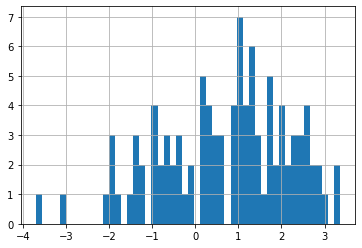

In [ ]:
ratings_grouped['rating_average'].hist(bins=50)

In [ ]:
C = ratings_grouped['rating_average'].mean()
print(f'average rating for the whole dataset: {C}')

average rating for the whole dataset: 0.7020177018236602


<AxesSubplot:>

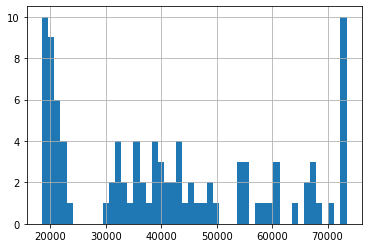

In [ ]:
ratings_grouped['rating_count'].hist(bins=50)

In [ ]:
m = ratings_grouped['rating_count'].min()
print(f'minimum votes required to be classified as popular: {m}')

minimum votes required to be classified as popular: 18505


### Подсчитаем взвешенные рейтинги шуток по формуле IMDB:

In [ ]:
def weighted_rating(x, m=m, C=C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> rating counts for each item (pd.Series)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for each item (pd.Series)
    C -> average rating for the whole dataset (float)
    
    Returns:
    pd.Series
    '''
    v = x['rating_count']
    R = x['rating_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

ratings_grouped['weighted_rating'] = ratings_grouped.apply(weighted_rating, axis=1)

ratings_grouped.sort_values('weighted_rating', ascending = False, inplace = True)

ratings_grouped['text'] = ratings_grouped['joke_id'].map(jokes_dict)

ratings_grouped.head(10)

,joke_id,rating_count,rating_average,weighted_rating,text
49,49,70449,3.36,2.81,"A guy goes into confession and says to the priest, ""Father, I'm 80 years old, widower, with 11 grandchildren. Last night I met two beautiful flight attendants. They took me home and I made love to both of them. Twice."" The priest said: ""Well, my son, when was the last time you were in confession?"" ""Never Father, I'm Jewish."" ""So then, why are you telling me?"" ""I'm telling everybody."""
31,31,66300,2.97,2.48,"A man arrives at the gates of heaven. St. Peter asks, ""Religion?"" The man says, ""Methodist."" St. Peter looks down his list, and says, ""Go to room 24, but be very quiet as you pass room 8."" Another man arrives at the gates of heaven. ""Religion?"" ""Baptist."" ""Go to room 18, but be very quiet as you pass room 8."" A third man arrives at the gates. ""Religion?"" ""Jewish."" ""Go to room 11, but be ..."
35,35,68137,2.92,2.44,"A guy walks into a bar, orders a beer and says to the bartender, ""Hey, I got this great Polish Joke..."" The barkeep glares at him and says in a warning tone of voice: ""Before you go telling that joke you better know that I'm Polish, both bouncers are Polish and so are most of my customers"" ""Okay"" says the customer,""I'll tell it very slowly."""
26,26,67718,2.91,2.43,"Clinton returns from a vacation in Arkansas and walks down the steps of Air Force One with two pigs under his arms. At the bottom of the steps, he says to the honor guardsman, ""These are genuine Arkansas Razor-Back Hogs. I got this one for Chelsea and this one for Hillary."" The guardsman replies, ""Nice trade, Sir."""
34,34,66460,2.78,2.32,"An explorer in the deepest Amazon suddenly finds himself surrounded by a bloodthirsty group of natives. Upon surveying the situation, he says quietly to himself, ""Oh God, I'm screwed."" The sky darkens and a voice booms out, ""No, you are NOT screwed. Pick up that stone at your feet and bash in the head of the chief standing in front of you."" So with the stone he bashes the life out of the c..."
61,61,63574,2.68,2.23,"A group of managers were given the assignment to measure the height of a flagpole. So they go out to the flagpole with ladders and tape measures, and they're falling off the ladders, dropping the tape measures - the whole thing is just a mess. An engineer comes along and sees what they're trying to do, walks over, pulls the flagpole out of the ground, lays it flat, measures it from end to end..."
28,28,67065,2.62,2.20,"An old Scotsmen is sitting with a younger Scottish gentleman and says the boy. ""Ah, lad look out that window. You see that stone wall there, I built it with me own bare hands, placed every stone meself. But do they call me MacGregor the wall builder? No! He Takes a few sips of his beer then says, ""Aye, and look out on that lake and eye that beautiful pier. I built it meself, laid every bo..."
52,52,67068,2.55,2.15,"One Sunday morning William burst into the living room and said, ""Dad! Mom! I have some great news for you! I am getting married to the most beautiful girl in town. She lives a block away and her name is Susan."" After dinner, William's dad took him aside. ""Son, I have to talk with you. Your mother and I have been married 30 years.. She's a wonderful wife but she has never offered much excitemen..."
48,48,60608,2.52,2.09,"Three engineering students were gathered together discussing the possible designers of the human body. One said, ""It was a mechanical engineer. Just look at all the joints."" Another said, ""No, it was an electrical engineer. The nervous systems many thousands of electrical connections."" The last said, ""Actually it was a civil engineer. Who else would run a toxic waste pipeline through a ..."
88,88,20443,3.35,2.09,"A radio conversation of a US naval ship with Canadian authorities ... Americans: Please divert your course 15 degrees to the North to avoid a collision. Canadians: Recommend you divert YOUR course 15 degrees to the South to a

### Новым user предлагаем шутки с наибольшим weighted_rating

### 2. Что делать в случае, если появляется новая шутка, по которой нет оценок или оценок слишком мало?

# Content-based модель: новую шутку можно предложить тем пользователям, которые хорошо оценили шутку, близкую к новой по косинусной мере

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english', min_df = 3, max_df = 10)

tfidf_matrix = tfidf.fit_transform(jokes['text'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix, )

In [ ]:
def get_recommendations(joke_id, cosine_sim, k):
    '''
    Return indices of jokes, which are closest to the current
    
    Args:
    joke_id -> indice of joke (int)
    cosine_sim -> cosine sim matrix (np.array)
    k -> nof tops (int)
    
    Returns:
    list
    '''
    
    sim_scores = list(enumerate(cosine_sim[joke_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]
    print(sim_scores)
    jokes_indices = [i[0] for i in sim_scores]
    return jokes_indices

### Предположим, что шутка joke_id == 96 новая:

In [ ]:
joke_id = 86

jokes.iloc[[joke_id]]

,joke_id,text
86,86,"A man, recently completing a routine physical examination receives a phone call from his doctor. The doctor says, ""I have some good news and some bad news."" The man says, ""OK, give me the good news first."" The doctor says, ""The good news is, you have 24 hours to live."" The man replies, ""Shit! That's the good news? Then what's the bad news?"" The doctor says, ""The bad news is, I forgot to..."


In [ ]:
k=1
print(f'top-{k}:')

print(['joke_id='+str(x)+': '+jokes_dict[x] for x in get_recommendations(joke_id, cosine_sim, k=k)])

top-1:
[(0, 0.7322801154226467)]
['joke_id=0: A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer\'s disease".  The man replies "Well,thank God I don\'t have cancer!"']


Шутку мы можем рекомендовать тем user_id, которые давали высокую оценку близкой шутке с joke_id=30

In [ ]:
ratings[(ratings.joke_id==30)&(ratings.rating>9)].sort_values('rating')[::-1]

,user_id,joke_id,rating
2276036,73406,30,9.76
2269563,66933,30,9.42
2234525,31895,30,9.37
2238224,35594,30,9.37
2238017,35387,30,9.37
...,...,...,...
2234499,31869,30,9.03
2233927,31297,30,9.03
2233744,31114,30,9.03
2211443,8813,30,9.03
